### 비교 실험
- 데이터는 가운데 5번째 1분만 사용
1. STFT + LSTM
2. STFT + LSTM AutoEncoder
3. STFT + Transformer
4. STFT + LSTM AutoEncoder + Attention
5. STFT + Conv LSTM

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
import scipy.signal
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model 
from keras.layers import (
    LSTM,
    Dense,
    Dropout,
    RepeatVector,
    TimeDistributed,
    Input,
    LeakyReLU,
    Layer,
    MultiHeadAttention,
    LayerNormalization,
    Add,
    GlobalAveragePooling1D,
    ConvLSTM2D,
    BatchNormalization,
    Attention,
    Conv3D,
    Reshape,
    TimeDistributed,
    Flatten,
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import kneighbors_graph
import os

In [2]:
# 데이터 파일 로드 및 정규화
def normalize_data(df, features):
    scaler = StandardScaler()
    return scaler.fit_transform(df[features])

In [3]:
RPM = 300
base_path = "5000hz_raw_data/" + str(RPM) + "rpm/"
folders = [
    str(RPM) + "rpm " + "normal data",
    str(RPM) + "rpm " + "carriage damage",
    str(RPM) + "rpm " + "high-speed damage",
    str(RPM) + "rpm " + "lack of lubrication",
    str(RPM) + "rpm " + "oxidation and corrosion",
]
columns = ["motor1_x", "motor1_y", "motor1_z", "sound", "time"]

In [4]:
# 데이터를 읽고 결합하는 함수
def read_and_concatenate(folder):
    all_files = []
    count = 4
    for file_name in os.listdir(folder):
        if count != 0:
            count -= 1
            continue

        if file_name.endswith(".csv"):
            file_path = os.path.join(folder, file_name)
            df = pd.read_csv(file_path, usecols=columns)
            all_files.append(df)
            
    combined_df = pd.concat(all_files)
    combined_df.sort_values("time", inplace=True)  # 시간 열 기준 정렬
    return combined_df

In [5]:
concatenated_df = dict()
folder_index = [
    "normal data",
    "carriage damage",
    "high-speed damage",
    "lack of lubrication",
    "oxidation and corrosion",
]
# 각 폴더에서 데이터를 처리
features = ["motor1_x", "motor1_y", "motor1_z", "sound"]
for index, folder_name in enumerate(folders):
    folder_path = os.path.join(base_path, folder_name)
    concatenated_df[folder_index[index]] = read_and_concatenate(folder_path)
    concatenated_df[folder_index[index]] = normalize_data(concatenated_df[folder_index[index]], features) # 정규화
    # time 열 제거
    # concatenated_df[folder_index[index]].drop(columns="time", inplace=True)

In [6]:
# STFT 수행
fs = 5000
def compute_stft(data):
    return np.array(
        [
            np.abs(scipy.signal.stft(d, fs=fs, nperseg=min(d.shape[-1], 256))[2])
            for d in data
        ]
    )  # 절대값을 사용하여 실수 데이터로 변환

In [7]:
for index, folder_name in enumerate(folders):
    concatenated_df[folder_index[index]] = compute_stft(
        concatenated_df[folder_index[index]]
    )

In [8]:
# STFT 데이터 합치기
def concatenate_data(*stft_data):
    min_time_steps = min(stft.shape[2] for stft in stft_data)
    return np.concatenate([stft[:, :, :min_time_steps] for stft in stft_data], axis=0)

In [9]:
for index, folder_name in enumerate(folders):
    concatenated_df[folder_index[index]] = concatenate_data(
        concatenated_df[folder_index[index]]
    )

In [10]:
# X 데이터 합치기
X = np.concatenate(
    [concatenated_df[folder_index[index]] for index, folder_name in enumerate(folders)],
    axis=0,
)

In [11]:
# 레이블 생성
Y = np.concatenate(
    (
        np.zeros(concatenated_df[folder_index[0]].shape[0]),
        np.ones(concatenated_df[folder_index[1]].shape[0]),
        np.full(concatenated_df[folder_index[2]].shape[0], 2),
        np.full(concatenated_df[folder_index[3]].shape[0], 3),
        np.full(concatenated_df[folder_index[4]].shape[0], 4),
    )
)
# 원핫 인코딩ㅇ
Y = to_categorical(Y)

In [12]:
# 데이터 분할 (6:2:2)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, test_size=0.25, random_state=42
)

In [13]:
# 데이터 형태 확인
# (데이터 수, 시간, 특징 수)
print("Train data shape:", X_train.shape)
print("Test data shape:", X_test.shape)
print("Validation data shape:", X_val.shape)
print("Train label shape:", Y_val.shape)
print("Train label shape:", Y_train.shape)
print("Test label shape:", Y_test.shape)


Train data shape: (5400000, 3, 3)
Test data shape: (1800000, 3, 3)
Validation data shape: (1800000, 3, 3)
Train label shape: (1800000, 5)
Train label shape: (5400000, 5)
Test label shape: (1800000, 5)


In [14]:
# 데이터 형태 변환  (샘플 수, 시간, 특징 수)
X_train = X_train.reshape(
    X_train.shape[0], X_train.shape[1], -1
)  
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], -1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

In [15]:
# 코드 확인
print("Train data shape after reshape:", X_train.shape)
print("Validation data shape after reshape:", X_val.shape)
print("Test data shape after reshape:", X_test.shape)

Train data shape after reshape: (5400000, 3, 3)
Validation data shape after reshape: (1800000, 3, 3)
Test data shape after reshape: (1800000, 3, 3)


### 1. STFT + LSTM

In [16]:
# LSTM 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2])
# LSTM Autoencoder 모델 정의
def create_lstm(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(128, activation="relu", return_sequences=True)(inputs)
    encoded = LSTM(64, activation="relu", return_sequences=True)(encoded)
    encoded = LSTM(32, activation="relu")(encoded)
    dense = Dense(64, activation="relu")(encoded)
    dropout = Dropout(0.2)(dense)
    outputs = Dense(5, activation="softmax")(dropout)
    model = Model(inputs, outputs)
    return model

In [17]:
# 모델 생성
model = create_lstm(input_shape)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_checkpoint = ModelCheckpoint(
    "best_model_1.keras", monitor="val_accuracy", save_best_only=True, mode="max"
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 128)         │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 64)          │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,845 (515.02 KB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# 얼리스탑 콜백 설정
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)


In [19]:
# 모델 훈련
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 287s 14ms/step - accuracy: 0.2481 - loss: 1.5750 - val_accuracy: 0.2779 - val_loss: 1.5370
Epoch 2/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 283s 13ms/step - accuracy: 0.3092 - loss: 1.4680 - val_accuracy: 0.5054 - val_loss: 1.1098
Epoch 3/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 281s 13ms/step - accuracy: 0.4843 - loss: 1.1040 - val_accuracy: 0.4798 - val_loss: 1.0846
Epoch 4/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 283s 13ms/step - accuracy: 0.5625 - loss: 0.9358 - val_accuracy: 0.6071 - val_loss: 0.8249
Epoch 5/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 285s 14ms/step - accuracy: 0.6236 - loss: 0.8154 - val_accuracy: 0.6820 - val_loss: 0.7152
Epoch 6/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 285s 14ms/step - accuracy: 0.6708 - loss: 0.7304 - val_accuracy: 0.6902 - val_loss: 0.6857
Epoch 7/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 286s 14ms/step - accuracy: 0.7054 - loss: 0.6626 - val_accuracy: 0.7539 - val_loss: 0.5685
Epoch 8/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 280

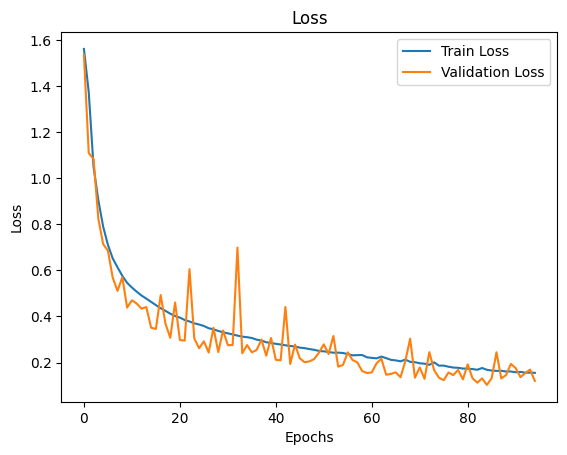

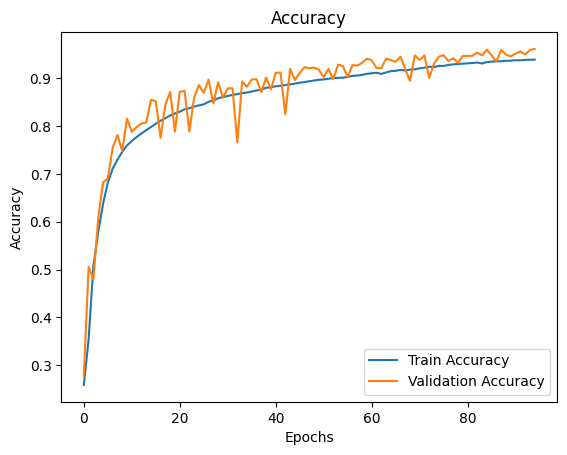

In [20]:
# STFT + LSTM 모델 평가
# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [21]:
model = load_model("best_model_1.keras")
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 예측 및 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step - accuracy: 0.9613 - loss: 0.0982
Test Loss: 0.09855084866285324
Test Accuracy: 0.9613455533981323
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 64s 1ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    360954
           1       0.98      0.97      0.98    359522
           2       0.97      0.93      0.95    360032
           3       0.98      0.96      0.97    359525
           4       0.91      0.96      0.94    359967

    accuracy                           0.96   1800000
   macro avg       0.96      0.96      0.96   1800000
weighted avg       0.96      0.96      0.96   1800000



### 2. STFT + LSTM Autoencoder

In [22]:
input_shape = (X_train.shape[1], X_train.shape[2])
# LSTM Autoencoder 모델 정의
def create_lstm_autoencoder(input_shape):
    inputs = Input(shape=input_shape)
    # Encoder
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32, return_sequences=False)(encoded)
    # Repeat Vector
    repeated = RepeatVector(input_shape[0])(encoded)
    # Decoder
    decoded = LSTM(32, return_sequences=True)(repeated)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    model = Model(inputs, outputs)
    return model

In [23]:
# Autoencoder에 인코딩된 특징을 활용하여 분류 모델 생성
def create_classifier(input_shape, num_classes):
    classifier = Sequential()
    classifier.add(Dense(64, input_shape=input_shape))
    classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU activation function
    classifier.add(Dropout(0.5))
    classifier.add(Dense(32))
    classifier.add(LeakyReLU(alpha=0.01))  # Leaky ReLU activation function
    classifier.add(Dropout(0.2))
    classifier.add(Dense(num_classes, activation="softmax"))

    classifier.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return classifier

In [24]:
# Autoencoder 모델 생성
model = create_lstm_autoencoder(input_shape)
model.compile(optimizer="adam", loss="mse")
model_checkpoint = ModelCheckpoint(
    "best_model_2.keras", monitor="val_loss", save_best_only=True, mode="min"
)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 3, 64)          │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 3, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 3)           │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,171 (246.76 KB)

 Trainable params: 63,171 (246.76 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# 모델 훈련
history = model.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 286s 7ms/step - loss: 0.0035 - val_loss: 8.7442e-05
Epoch 2/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 289s 7ms/step - loss: 2.1332e-05 - val_loss: 7.9681e-04
Epoch 3/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 294s 7ms/step - loss: 1.5036e-05 - val_loss: 1.6997e-06
Epoch 4/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 294s 7ms/step - loss: 1.0171e-05 - val_loss: 8.0567e-06
Epoch 5/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 299s 7ms/step - loss: 1.0989e-05 - val_loss: 7.2769e-07


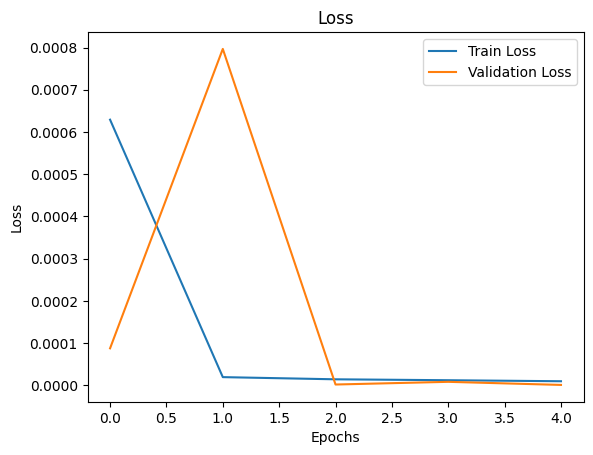

In [26]:
# 훈련 및 검증 데이터에 대한 손실 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
model = load_model("best_model_2.keras")
# LSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[2].output)
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

168750/168750 ━━━━━━━━━━━━━━━━━━━━ 89s 527us/step
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 29s 523us/step
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 29s 523us/step


In [28]:
# 다중 클래스 분류 모델 생성
classifier = create_classifier((X_train_encoded.shape[1],), 5)
classifier.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
classifier.summary()

/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357 (17.02 KB)

 Trainable params: 4,357 (17.02 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 다중 클래스 분류 모델 훈련
history = classifier.fit(
    X_train_encoded,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_encoded, Y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 20s 921us/step - accuracy: 0.2471 - loss: 1.5773 - val_accuracy: 0.2659 - val_loss: 1.5588
Epoch 2/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 859us/step - accuracy: 0.2586 - loss: 1.5649 - val_accuracy: 0.2701 - val_loss: 1.5523
Epoch 3/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 19s 910us/step - accuracy: 0.2610 - loss: 1.5617 - val_accuracy: 0.2787 - val_loss: 1.5455
Epoch 4/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 864us/step - accuracy: 0.2642 - loss: 1.5574 - val_accuracy: 0.2843 - val_loss: 1.5321
Epoch 5/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 869us/step - accuracy: 0.2682 - loss: 1.5500 - val_accuracy: 0.2898 - val_loss: 1.5197
Epoch 6/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 19s 882us/step - accuracy: 0.2747 - loss: 1.5414 - val_accuracy: 0.3136 - val_loss: 1.4896
Epoch 7/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 866us/step - accuracy: 0.2868 - loss: 1.5219 - val_accuracy: 0.3354 - val_loss: 1.4359
Epoch 8/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 20s

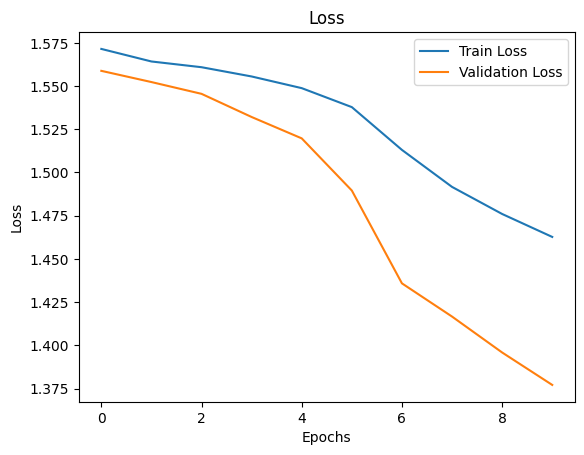

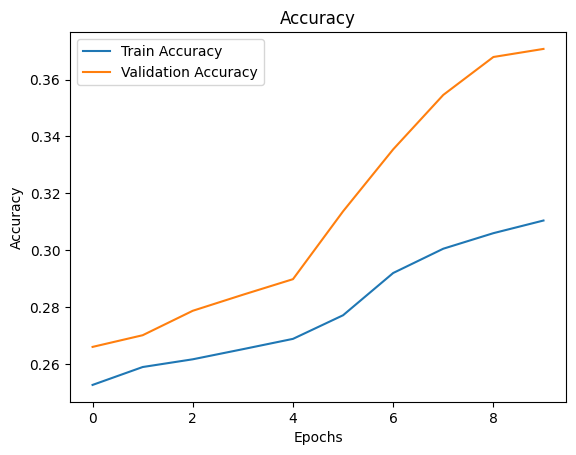

In [30]:
# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [31]:
# 모델 평가
test_loss, test_accuracy = classifier.evaluate(X_test_encoded, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 예측 및 성능 평가
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 19s 331us/step - accuracy: 0.3708 - loss: 1.3766
Test Loss: 1.3765547275543213
Test Accuracy: 0.37091222405433655
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 14s 250us/step
              precision    recall  f1-score   support

           0       0.36      0.33      0.34    360954
           1       0.34      0.29      0.31    359522
           2       0.33      0.26      0.29    360032
           3       0.39      0.45      0.42    359525
           4       0.41      0.53      0.46    359967

    accuracy                           0.37   1800000
   macro avg       0.37      0.37      0.36   1800000
weighted avg       0.37      0.37      0.36   1800000



### 3. STFT + Transformer

In [32]:
# Transformer 모델 생성
input_shape = (X_train.shape[1], X_train.shape[2])

def create_transformer_model(input_shape, num_heads=4, ff_dim=32):
    inputs = Input(shape=input_shape)
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[1])(
        inputs, inputs
    )
    attn_output = Dropout(0.1)(attn_output)
    attn_output = LayerNormalization(epsilon=1e-6)(attn_output + inputs)

    ff_output = Dense(ff_dim, activation="relu")(attn_output)
    ff_output = Dense(input_shape[1])(ff_output)
    ff_output = Dropout(0.1)(ff_output)
    ff_output = LayerNormalization(epsilon=1e-6)(ff_output + attn_output)

    outputs = GlobalAveragePooling1D()(ff_output)
    outputs = Dense(5, activation="softmax")(outputs)

    model = Model(inputs, outputs)
    return model

In [33]:
# Transformer 모델 생성
model = create_transformer_model(input_shape)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_checkpoint = ModelCheckpoint(
    "best_model_3.keras", monitor="val_accuracy", save_best_only=True, mode="max"
)
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 3, 3)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 3)      │        183 │ input_layer_3[0]… │
│ (MultiHeadAttentio… │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 3, 3)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 3, 3)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 3, 3)      │          6 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3, 32)     │        128 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3, 3)      │         99 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 3, 3)      │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 3, 3)      │          0 │ dropout_5[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 3)      │          6 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 3)         │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │         20 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 442 (1.73 KB)

 Trainable params: 442 (1.73 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# 모델 훈련
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step - accuracy: 0.2024 - loss: 1.6133 - val_accuracy: 0.2108 - val_loss: 1.6076
Epoch 2/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.2104 - loss: 1.6068 - val_accuracy: 0.2135 - val_loss: 1.6065
Epoch 3/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.2104 - loss: 1.6037 - val_accuracy: 0.2121 - val_loss: 1.6026
Epoch 4/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - accuracy: 0.2088 - loss: 1.6047 - val_accuracy: 0.2162 - val_loss: 1.6025
Epoch 5/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.2106 - loss: 1.6031 - val_accuracy: 0.2105 - val_loss: 1.6075
Epoch 6/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.2117 - loss: 1.6072 - val_accuracy: 0.2118 - val_loss: 1.6057
Epoch 7/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.2137 - loss: 1.6055 - val_accuracy: 0.2165 - val_loss: 1.6050
Epoch 8/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 49s 2ms/step - ac

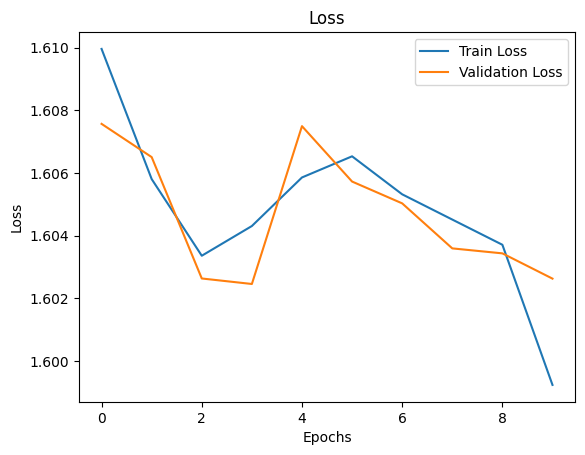

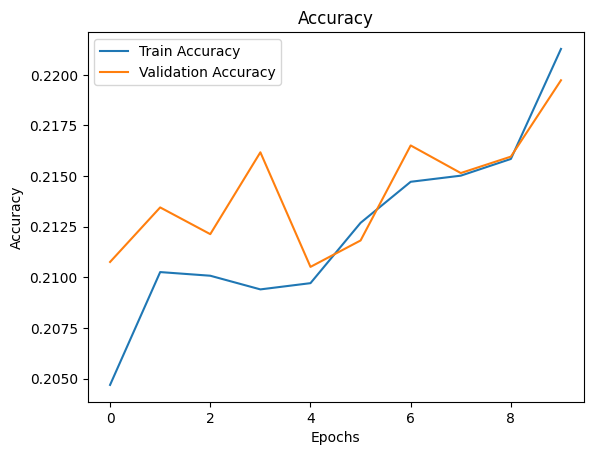

In [35]:
# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [36]:
model = load_model("best_model_3.keras")
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
 
# 예측 및 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 23s 408us/step - accuracy: 0.2189 - loss: 1.6031
Test Loss: 1.6030333042144775
Test Accuracy: 0.21911221742630005
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 21s 377us/step


/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.26      0.13      0.17    360954
           1       0.20      0.33      0.25    359522
           2       0.21      0.29      0.24    360032
           3       0.00      0.00      0.00    359525
           4       0.23      0.35      0.28    359967

    accuracy                           0.22   1800000
   macro avg       0.18      0.22      0.19   1800000
weighted avg       0.18      0.22      0.19   1800000



/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### 4. STFT + LSTM AutoEncoder + Attention

In [37]:
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(
            name="attention_weight",
            shape=(input_shape[-1], input_shape[-1]),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            name="attention_bias",
            shape=(input_shape[-1],),
            initializer="zeros",
            trainable=True,
        )
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a
        return K.sum(output, axis=1)

In [38]:
input_shape = (X_train.shape[1], X_train.shape[2])
# LSTM Autoencoder 모델 정의 (Attention 추가)
def create_lstm_ae_with_attention(input_shape):
    inputs = Input(shape=input_shape)
    encoded = LSTM(64, return_sequences=True)(inputs)
    encoded = LSTM(32, return_sequences=True)(encoded)
    attention = Attention()(encoded)
    repeated = RepeatVector(input_shape[0])(attention)
    decoded = LSTM(32, return_sequences=True)(repeated)
    decoded = LSTM(64, return_sequences=True)(decoded)
    outputs = TimeDistributed(Dense(input_shape[1]))(decoded)
    model = Model(inputs, outputs)
    return model

In [39]:
# Autoencoder 모델 생성
model = create_lstm_ae_with_attention(input_shape)
model.compile(optimizer="adam", loss="mse")
model_checkpoint = ModelCheckpoint(
    "best_model_4.keras", monitor="val_loss", save_best_only=True, mode="min"
)
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 3, 3)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 64)          │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention (Attention)           │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 3, 32)          │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 3)           │           195 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,227 (250.89 KB)

 Trainable params: 64,227 (250.89 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# 모델 훈련
history = model.fit(
    X_train,
    X_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 338s 8ms/step - loss: 0.0036 - val_loss: 8.3209e-06
Epoch 2/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 330s 8ms/step - loss: 2.8157e-05 - val_loss: 2.4619e-06
Epoch 3/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 323s 8ms/step - loss: 1.3816e-05 - val_loss: 2.3083e-06
Epoch 4/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 322s 8ms/step - loss: 1.0911e-05 - val_loss: 1.1551e-06
Epoch 5/5
42188/42188 ━━━━━━━━━━━━━━━━━━━━ 324s 8ms/step - loss: 8.6313e-06 - val_loss: 4.4896e-06


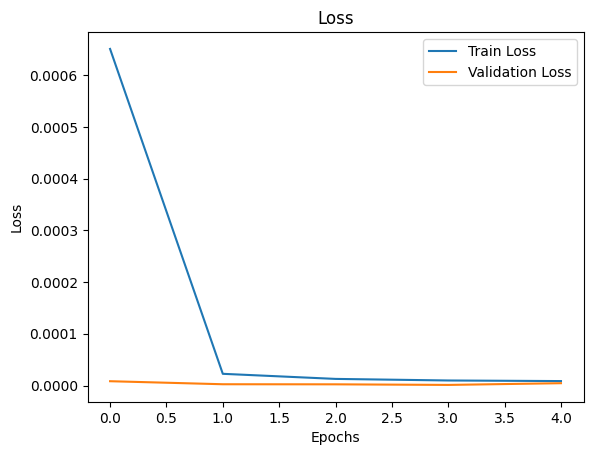

In [41]:
# 훈련 및 검증 데이터에 대한 손실 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [43]:
# LSTM Autoencoder에서 인코딩된 특징 추출
encoder = Model(inputs=model.input, outputs=model.layers[3].output)
X_train_encoded = encoder.predict(X_train)
X_val_encoded = encoder.predict(X_val)
X_test_encoded = encoder.predict(X_test)

168750/168750 ━━━━━━━━━━━━━━━━━━━━ 112s 666us/step
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 37s 664us/step
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 38s 667us/step


In [44]:
# 다중 클래스 분류 모델 생성
classifier = create_classifier((X_train_encoded.shape[1],), 5)
classifier.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)
classifier.summary()

/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/jeongseonghun/.pyenv/versions/3.10.11/envs/ml-job/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,357 (17.02 KB)

 Trainable params: 4,357 (17.02 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# 다중 클래스 분류 모델 훈련
history = classifier.fit(
    X_train_encoded,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val_encoded, Y_val),
    callbacks=[early_stopping],
)

Epoch 1/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 19s 865us/step - accuracy: 0.2436 - loss: 1.5796 - val_accuracy: 0.2628 - val_loss: 1.5587
Epoch 2/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 19s 873us/step - accuracy: 0.2573 - loss: 1.5645 - val_accuracy: 0.2713 - val_loss: 1.5470
Epoch 3/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 857us/step - accuracy: 0.2611 - loss: 1.5582 - val_accuracy: 0.2745 - val_loss: 1.5393
Epoch 4/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 866us/step - accuracy: 0.2638 - loss: 1.5537 - val_accuracy: 0.2772 - val_loss: 1.5329
Epoch 5/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 859us/step - accuracy: 0.2663 - loss: 1.5495 - val_accuracy: 0.2843 - val_loss: 1.5263
Epoch 6/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 858us/step - accuracy: 0.2690 - loss: 1.5458 - val_accuracy: 0.2886 - val_loss: 1.5227
Epoch 7/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 18s 864us/step - accuracy: 0.2701 - loss: 1.5439 - val_accuracy: 0.2868 - val_loss: 1.5172
Epoch 8/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 19s

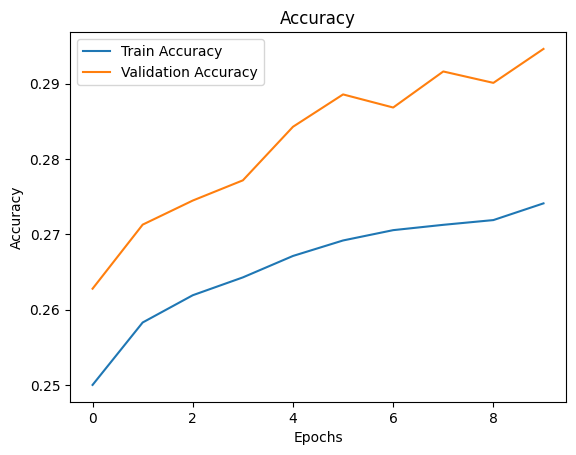

In [46]:
# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [47]:
# 모델 평가
test_loss, test_accuracy = classifier.evaluate(X_test_encoded, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 예측 및 성능 평가
y_pred = classifier.predict(X_test_encoded)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 18s 326us/step - accuracy: 0.2947 - loss: 1.5115
Test Loss: 1.5116548538208008
Test Accuracy: 0.29461055994033813
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 15s 260us/step
              precision    recall  f1-score   support

           0       0.28      0.25      0.26    360954
           1       0.27      0.21      0.24    359522
           2       0.28      0.11      0.16    360032
           3       0.29      0.40      0.34    359525
           4       0.32      0.50      0.39    359967

    accuracy                           0.29   1800000
   macro avg       0.29      0.29      0.28   1800000
weighted avg       0.29      0.29      0.28   1800000



### 5.  STFT + Conv LSTM

In [48]:
# ConvLSTM + Attention 모델 생성
def create_convlstm(input_shape):
    inputs = Input(shape=input_shape)
    conv_lstm = ConvLSTM2D(
        filters=64, kernel_size=(3, 1), padding="same", return_sequences=True
    )(inputs)
    conv_lstm = BatchNormalization()(conv_lstm)
    conv_lstm = ConvLSTM2D(
        filters=32, kernel_size=(3, 1), padding="same", return_sequences=True
    )(conv_lstm)
    conv_lstm = BatchNormalization()(conv_lstm)

    conv_lstm_decoded = ConvLSTM2D(
        filters=32, kernel_size=(3, 1), padding="same", return_sequences=True
    )(conv_lstm)
    conv_lstm_decoded = BatchNormalization()(conv_lstm_decoded)
    conv_lstm_decoded = ConvLSTM2D(
        filters=64, kernel_size=(3, 1), padding="same", return_sequences=True
    )(conv_lstm_decoded)
    conv_lstm_decoded = BatchNormalization()(conv_lstm_decoded)
    outputs = Flatten()(conv_lstm_decoded)
    outputs = Dense(5, activation="softmax")(outputs)

    model = Model(inputs, outputs)
    return model

In [49]:
# 데이터 변환
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2], 1, 1)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], X_val.shape[2], 1, 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2], 1, 1)

In [50]:
# 데이터 형태 확인
print("Train data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Test data shape:", X_test.shape)
print("Train label shape:", Y_train.shape)
print("Validation label shape:", Y_val.shape)
print("Test label shape:", Y_test.shape)

Train data shape: (5400000, 1, 3, 3, 1, 1)
Validation data shape: (1800000, 1, 3, 3, 1, 1)
Test data shape: (1800000, 1, 3, 3, 1, 1)
Train label shape: (5400000, 5)
Validation label shape: (1800000, 5)
Test label shape: (1800000, 5)


In [51]:
# 입력 형태 정의
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3], X_train.shape[4])

In [52]:
# ConvLSTM 모델 생성
model = create_convlstm(input_shape)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model_checkpoint = ModelCheckpoint(
    "best_model_5.keras", monitor="val_accuracy", save_best_only=True, mode="max"
)
model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 3, 3, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d (ConvLSTM2D)        │ (None, 1, 3, 3, 64)    │        50,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1, 3, 3, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 1, 3, 3, 32)    │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1, 3, 3, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 1, 3, 3, 32)    │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1, 3, 3, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 1, 3, 3, 64)    │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1, 3, 3, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │         2,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,509 (740.27 KB)

 Trainable params: 189,125 (738.77 KB)

 Non-trainable params: 384 (1.50 KB)

In [53]:
# 모델 훈련
history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=256,
    validation_data=(X_val, Y_val),
    callbacks=[early_stopping, model_checkpoint],
)

Epoch 1/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 671s 32ms/step - accuracy: 0.4390 - loss: 1.2153 - val_accuracy: 0.5051 - val_loss: 1.4633
Epoch 2/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 671s 32ms/step - accuracy: 0.8359 - loss: 0.3958 - val_accuracy: 0.7932 - val_loss: 0.5649
Epoch 3/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 672s 32ms/step - accuracy: 0.9380 - loss: 0.1593 - val_accuracy: 0.9428 - val_loss: 0.1311
Epoch 4/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 712s 34ms/step - accuracy: 0.9576 - loss: 0.1100 - val_accuracy: 0.9619 - val_loss: 0.0921
Epoch 5/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 717s 34ms/step - accuracy: 0.9644 - loss: 0.0930 - val_accuracy: 0.9737 - val_loss: 0.0621
Epoch 6/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 735s 35ms/step - accuracy: 0.9694 - loss: 0.0786 - val_accuracy: 0.9657 - val_loss: 0.0770
Epoch 7/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 703s 33ms/step - accuracy: 0.9715 - loss: 0.0755 - val_accuracy: 0.9817 - val_loss: 0.0448
Epoch 8/100
21094/21094 ━━━━━━━━━━━━━━━━━━━━ 697

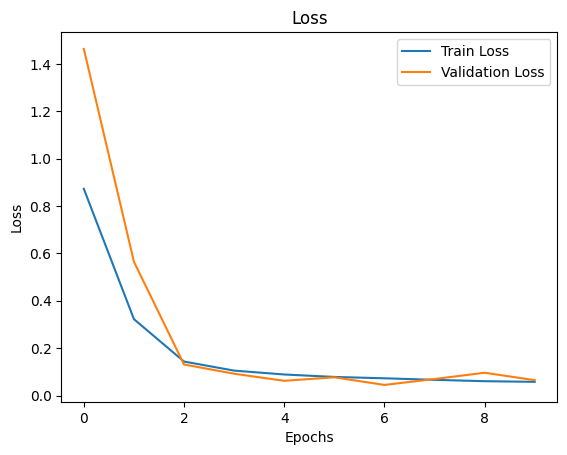

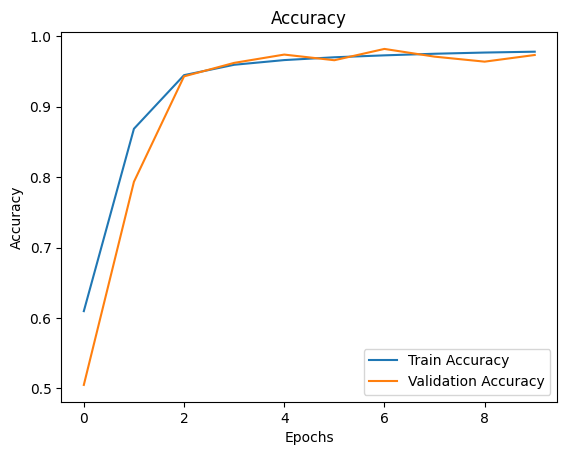

In [54]:
# 훈련 및 검증 데이터에 대한 손실 및 정확도 그래프
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]

plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracy, label="Train Accuracy")
plt.plot(val_accuracy, label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [55]:
model = load_model("best_model_5.keras")
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# 예측 및 성능 평가
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(Y_test, axis=1)

print(classification_report(y_true_classes, y_pred_classes))

56250/56250 ━━━━━━━━━━━━━━━━━━━━ 192s 3ms/step - accuracy: 0.9816 - loss: 0.0449
Test Loss: 0.045016635209321976
Test Accuracy: 0.9815278053283691
56250/56250 ━━━━━━━━━━━━━━━━━━━━ 193s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    360954
           1       0.98      0.98      0.98    359522
           2       0.98      0.98      0.98    360032
           3       0.98      0.99      0.98    359525
           4       0.99      0.98      0.98    359967

    accuracy                           0.98   1800000
   macro avg       0.98      0.98      0.98   1800000
weighted avg       0.98      0.98      0.98   1800000

